## Data Reading and Preprocessing

In [510]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

In [511]:
data=pd.read_csv('Housing.csv')

In [512]:
display(data.size)
display(data.shape)
display(data.info())
display(data.head())

7085

(545, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


None

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [513]:
print("NAN")
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])

print("\nNULL")
null_counts = data.isnull().sum()
print(null_counts[null_counts > 0])

NAN
Series([], dtype: int64)

NULL
Series([], dtype: int64)


In [514]:
numeric_data=data.select_dtypes(exclude=['object']).columns
print("Numerical Features:",len(list(numeric_data)),"\n",list(numeric_data))
categorical_data=data.select_dtypes(include=['object']).columns
print("Categorial Features:",len(list(categorical_data)),"\n",list(categorical_data))

Numerical Features: 6 
 ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorial Features: 7 
 ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [515]:
for col in data.select_dtypes(include=['object']):
        data[col] = data[col].str.lower().str.strip()

In [516]:
def remove_outliers(data):
    df_clean = data.copy()
    initial_rows = len(df_clean)
    
    for col in df_clean.select_dtypes(exclude=['object']).columns:
        Q1 = df_clean[col].quantile(0.15)
        Q3 = df_clean[col].quantile(0.85)
        IQR = Q3 - Q1
        df_clean = df_clean[(df_clean[col] >= Q1 - 1.5 * IQR) & 
                           (df_clean[col] <= Q3 + 1.5 * IQR)]
    
    removed = initial_rows - len(df_clean)
    display(f"Removed {removed} outliers ({removed/initial_rows:.2%} of data)")
    return df_clean


data = remove_outliers(data)

'Removed 50 outliers (9.17% of data)'

In [517]:
def z_score_outliers(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return z_scores > threshold

outliers_dict = {}
for col in numeric_data:
    mask = z_score_outliers(data[col])
    outliers_dict[col] = data[mask].shape[0]

combined_mask = pd.DataFrame({col: z_score_outliers(data[col]) for col in numeric_data})
any_outlier = combined_mask.any(axis=1)
total_outliers = any_outlier.sum()
outlier_percentage = (total_outliers / len(data)) * 100
display(f"Removed: {total_outliers} outliers ({outlier_percentage:.2f}%) of data")

'Removed: 17 outliers (3.43%) of data'

In [518]:
from sklearn.ensemble import IsolationForest

def isolation_forest_outliers(data):
    data_cleaned = data.copy()    
    outlier_masks = {}
    
    for col in data.select_dtypes(exclude=['object']).columns:
        column_data = data[col].values.reshape(-1, 1)
        clf = IsolationForest(
            n_estimators=200,
            max_samples=0.7,
            contamination=0.005,
            random_state=1
        )
        preds = clf.fit_predict(column_data)
        outlier_masks[col] = pd.Series((preds == -1), index=data.index)

    combined_mask = pd.DataFrame(outlier_masks, index=data.index)
    rows_with_outliers = combined_mask.any(axis=1)

    data_cleaned = data_cleaned.loc[~rows_with_outliers]

    outlier_count = rows_with_outliers.sum()
    outlier_percent = (outlier_count / len(data)) * 100
    print(f"Removed {outlier_count} outliers ({outlier_percent:.2f}% of data)")

    for col in outlier_masks:
        col_outliers = outlier_masks[col].sum()
    
    return data_cleaned

data = isolation_forest_outliers(data)

Removed 8 outliers (1.62% of data)


In [519]:
for col in data.select_dtypes(include=['object']).columns:
    display(data[col].value_counts())

mainroad
yes    411
no      76
Name: count, dtype: int64

guestroom
no     403
yes     84
Name: count, dtype: int64

basement
no     307
yes    180
Name: count, dtype: int64

hotwaterheating
no     463
yes     24
Name: count, dtype: int64

airconditioning
no     355
yes    132
Name: count, dtype: int64

prefarea
no     376
yes    111
Name: count, dtype: int64

furnishingstatus
semi-furnished    210
unfurnished       162
furnished         115
Name: count, dtype: int64

In [520]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col]=encoder.fit_transform(data[col])

In [521]:
from sklearn.preprocessing import StandardScaler
def scaled_data(data):
    data_copy = data.copy()
    scaler = StandardScaler()
    data_copy[numeric_data] = scaler.fit_transform(data_copy[numeric_data]) 
    return data_copy
scalled_data= scaled_data(data)

<Axes: >

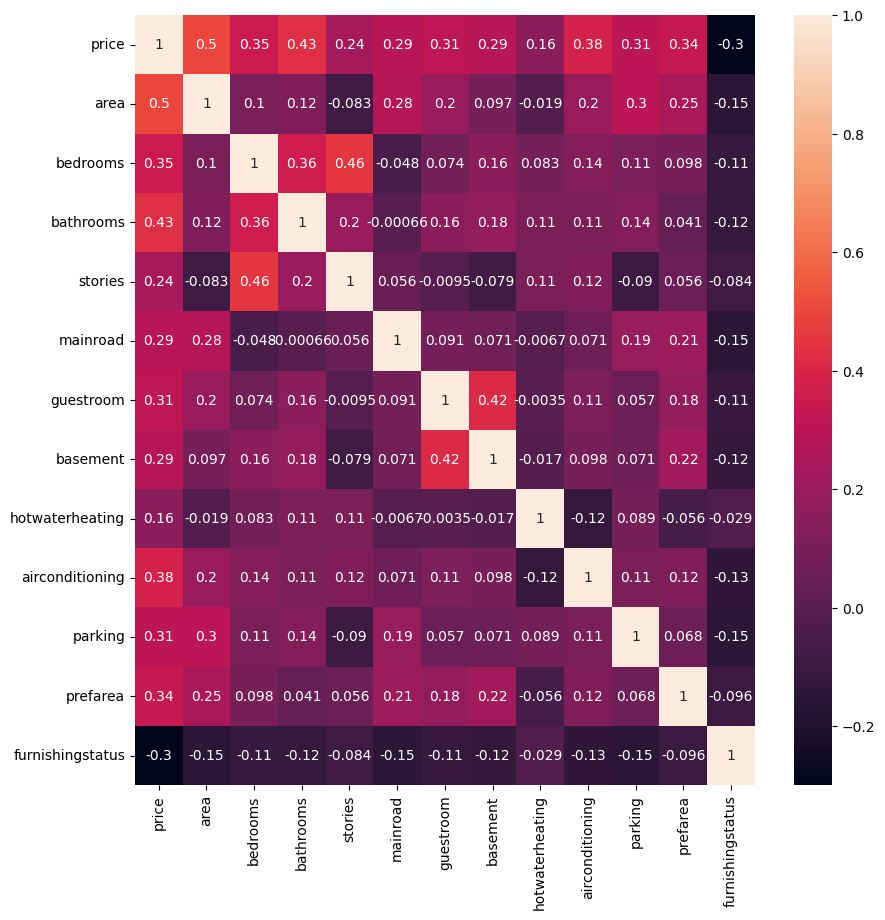

In [522]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)

In [523]:
x = scalled_data.iloc[:, 1:]
y = scalled_data.iloc[:, 0]

def correlation(x,y,threshold):
    to_drop=[]
    for col in x.columns:
        CORR=abs(np.corrcoef(x[col],y)[0,1])
        if CORR>threshold:
            to_drop.append(col)
    return to_drop
to_drop=correlation(x,y,0.7)
display(list(to_drop))
data=data.drop(to_drop,axis=1)

[]

## Regression

Simple Linear Regression

In [524]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = data[['price']]
y = data[['area']]

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model.fit(x_train, y_train)
model.score(x_test, y_test)

0.19874919199057106

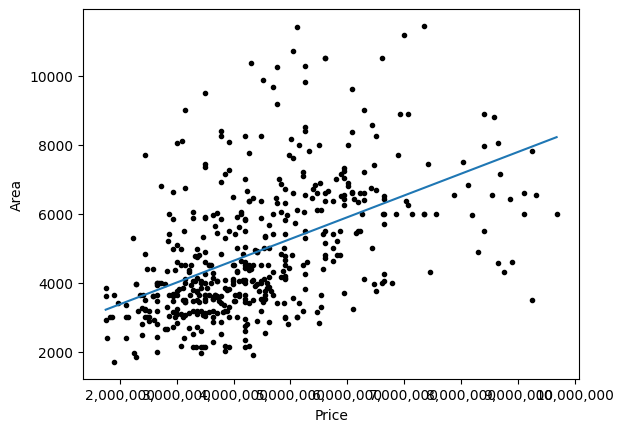

In [525]:
plt.plot(x, y,'.k')
plt.xlabel('Price')
plt.ylabel('Area')
plt.plot(x, model.predict(x))

from matplotlib.ticker import StrMethodFormatter
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

In [526]:
print ('Residual sum of squares: %.2f' % np.mean((model.predict(x)- y) ** 2))

Residual sum of squares: 2705494.22


Multiple Linear Regression

In [527]:
x=data.iloc[:,1:]
y=data.iloc[:,0]

model=LinearRegression()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

model.fit(x_train,y_train)
model.score(x_test,y_test)

0.5068420973493095

In [528]:
print ('Residual sum of squares: %.2f' % np.mean((model.predict(x)- y) ** 2))

Residual sum of squares: 922681440879.91


Ploynomial Regression

In [529]:
#not yet capable